### Imports

In [15]:
import os
import pymysql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from customerclustering.db_connection import Db
from customerclustering.get_training_data import GetTrainingData

In [4]:
conn = Db.db_conn()

In [48]:
env_path = find_dotenv()
load_dotenv(env_path)

conn = pymysql.connect (
    host = os.getenv('HOST'),
    port = int(3306),
    user = os.getenv('USER_DB'),
    password = os.getenv('PASSWORD_DB'),
    db = os.getenv('DB'),
    charset = 'utf8mb4'
)

## Query 1: Ratio of users subscribed to account age

In [8]:
def get_ratio_subs_per_user(conn):
    df = pd.read_sql_query(
        """
            SELECT 
                Product, 
                Status, 
                userID,
                stripeCustID,
                COUNT(*) AS num_subs,
                DATEDIFF(NOW(), createDate) AS account_age
            FROM stripe_subscription
            JOIN user ON user.stripeCustID = stripe_subscription.`Customer ID`
            GROUP BY `Customer ID` 
            ORDER BY COUNT(*) DESC
        """, conn)
    
    return df

df_subs_per_user = get_ratio_subs_per_user(conn)

In [9]:
df_subs_per_user

,Product,Status,userID,stripeCustID,num_subs,account_age
0,Ausmed Subscription,incomplete_expired,b844dd04-799b-4d74-aa89-e3d91e6b135b,cus_CwbLsaFBPovaL4,14,1537.0
1,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1608.0
2,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1228.0
3,Ausmed Subscription,incomplete_expired,d83f7491-9780-4568-a1c1-fd4c82434a06,cus_JIgpIXgpkkotwL,8,484.0
4,Ausmed Subscription,incomplete_expired,cfe4c603-9844-4549-9e37-37786e45a762,cus_Cvl36O6MtngQRg,7,1539.0
...,...,...,...,...,...,...
29111,Ausmed Subscription,active,fff5b6ec-0f17-4c0f-acdb-caf5a54d440c,cus_AlI7ExGfEYx9BI,1,1977.0
29112,Ausmed Subscription,active,fff61169-6743-4b75-b100-3603d1c02082,cus_HBQubDAIn90yiH,1,835.0
29113,Ausmed Subscription,active,fff6edf1-916e-496e-b811-ec8a60b4dc3f,cus_Htf9RoTV17oNz6,1,717.0
29114,Ausmed Subscription,canceled,fff8d7d8-d0a5-4fb1-9e1f-a6063f16c28d,cus_IjezQrGVvBmqui,1,578.0


In [10]:
df_subs_per_user['subs_to_age_ratio'] = round(df_subs_per_user["account_age"] / df_subs_per_user["num_subs"],0)

[Text(0.5, 1.0, 'Ratio of times a subscriber subscribed divided by their account age in days')]

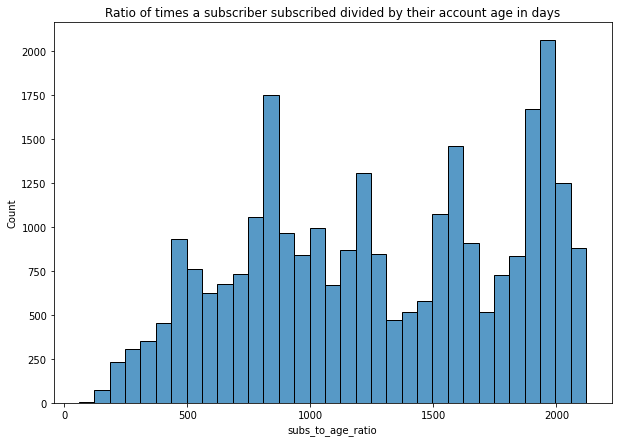

In [11]:
plt.figure(figsize=(10, 7))
sns.histplot(df_subs_per_user['subs_to_age_ratio']).set(title = "Ratio of times a subscriber subscribed divided by their account age in days")


## Query 2: Minutes documented per user (total)

In [ ]:
def get_total_mins_doc(conn):
    df_doc = pd.read_sql_query(
        """
        SELECT
            owner,
            SUM(min) AS total_mins_doc,
            COUNT(*) AS total_docs
        FROM activity_20220808
        GROUP BY owner
        """, conn)
    
    df_doc['mins_per_documentation'] = round(df_doc['total_mins'] / df_doc['total_docs'], 0)
    
    return df_doc

df_doc = get_total_mins_doc(conn)

/Users/benquartermaine/.pyenv/versions/3.8.12/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
df_doc['mins_per_documentation'] = round(df_doc['total_mins'] / df_doc['total_docs'], 0)

In [ ]:
df_doc

## Query 3: Did a user activate (2 documentations in the first 30 days?)

In [23]:
def get_users(conn):

    df_users = pd.read_sql_query(
            """
            SELECT 
                userID,
                user.createDate AS account_create
            FROM user""", conn)
    df_users = df_users.dropna()
    
    return df_users

In [26]:
df_user = get_users(conn)

/Users/benquartermaine/.pyenv/versions/3.8.12/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [30]:
train = GetTrainingData(conn = conn, rows = 2000)

In [31]:
t = train.activity_table_df()

/Users/benquartermaine/.pyenv/versions/3.8.12/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [32]:
t.head()

,activityID,owner,title,activityType,goals,qualifications,resource,providerName,startDate,endDate,...,authorNames,publisher,purpose,involvement,outcome,focus,colleague,topicTags,competencyStandards,accreditations


In [7]:
def get_activity_for_users(conn, rows = 2000):
    
    """Return a dataframe with userID, user create date, and all users activities documented"""
    df_activity = GetTrainingData(conn = conn, rows = rows).activity_table_df()
    df_user = get_users(conn)
    
    df_user_activity = df_user.join(other = df_activity, on = '', how = inner)
    df = pd.read_sql_query(
        """
        SELECT 
            userID,
            activityID,
            user.createDate AS account_create,
            activity_20220808.createDate AS act_create
        FROM user
        JOIN activity_20220808 ON owner = userID
        LIMIT 10000""", conn)
    
    return df

df_acts = get_users_activities(conn)

/Users/benquartermaine/.pyenv/versions/3.8.12/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [8]:
df_acts = df_acts.dropna()
df_acts['date_diff'] = df_acts['act_create'] - df_acts['account_create']

In [113]:
acts_count = df_acts[['userID']].groupby(df_acts['userID'])[['userID']].count()
acts_count.rename(columns={'userID': 'count'}, inplace = True)

In [115]:
df_acts = pd.merge(df_acts, acts_count, how = 'outer', on = 'userID')

In [116]:
df_acts

,userID,activityID,account_create,act_create,date_diff,count
0,00001d9c-5de5-4ed2-9ecc-98341286765a,396db1ee-fdb1-4a23-acb7-885add162c1b,2018-07-02 17:26:13,2020-11-11 16:23:48,862 days 22:57:35,7
1,00001d9c-5de5-4ed2-9ecc-98341286765a,6efcc6bc-8109-4874-9677-ab0111a53994,2018-07-02 17:26:13,2020-11-11 17:39:34,863 days 00:13:21,7
2,00001d9c-5de5-4ed2-9ecc-98341286765a,902be558-b15d-4e00-bfd3-96d19c7cdd99,2018-07-02 17:26:13,2020-04-23 19:29:56,661 days 02:03:43,7
3,00001d9c-5de5-4ed2-9ecc-98341286765a,9da2a61f-a16f-4670-b762-e039e97f0d9d,2018-07-02 17:26:13,2020-05-04 18:32:55,672 days 01:06:42,7
4,00001d9c-5de5-4ed2-9ecc-98341286765a,9b0d1b5d-1e34-46c9-8a6b-b0a2902401e7,2018-07-02 17:26:13,2020-08-22 20:46:18,782 days 03:20:05,7
...,...,...,...,...,...,...
9475,009f006f-a514-4be1-ae71-5785582187fc,f5a6ae4f-796a-43db-95d6-a1540be7363e,2017-03-15 16:12:45,2021-11-09 07:37:52,1699 days 15:25:07,42
9476,009f006f-a514-4be1-ae71-5785582187fc,1167ff6b-c4a1-431a-a1f7-6860d228f952,2017-03-15 16:12:45,2018-09-12 23:05:57,546 days 06:53:12,42
9477,009f006f-a514-4be1-ae71-5785582187fc,6bcbd703-401e-4e90-9efe-9d7673e68450,2017-03-15 16:12:45,2019-05-14 21:41:26,790 days 05:28:41,42
9478,009f006f-a514-4be1-ae71-5785582187fc,aa31660e-30c4-4a55-b596-eb97fba7b06b,2017-03-15 16:12:45,2017-10-20 17:41:49,219 days 01:29:04,42


In [126]:
df_acts['date_diff'] = df_acts['date_diff'].dt.days

In [133]:
df_acts[(df_acts['date_diff'] < 30) & (df_acts['count'] >  0)]

,userID,activityID,account_create,act_create,date_diff,count
7,00001fb9-98c7-4dd4-b922-40a4094cd0d8,2b10aca2-9ca0-475a-9e28-b28d28ae3806,2017-09-07 01:48:02,2017-09-26 12:45:58,19,8
9,00001fb9-98c7-4dd4-b922-40a4094cd0d8,60caaf67-0afb-4f8b-8b5a-aeebca5c6253,2017-09-07 01:48:02,2017-09-24 10:39:29,17,8
34,00013cfc-f97f-428d-bf6b-558601512bd7,00c77809-2525-4f49-a79a-6a57737ea159,2017-05-25 02:18:02,2017-05-25 02:44:32,0,16
41,00013cfc-f97f-428d-bf6b-558601512bd7,1144a29e-a4b0-46b9-a08d-bb61258c3573,2017-05-25 02:18:02,2017-05-25 22:30:49,0,16
43,00013cfc-f97f-428d-bf6b-558601512bd7,56a25876-af4a-4fa3-a477-29e7490b927f,2017-05-25 02:18:02,2017-05-25 22:45:27,0,16
...,...,...,...,...,...,...
9416,009e7816-cd70-47b8-95b6-b626a0ba6567,772d3c85-0525-45e6-bd94-bd030faf9d44,2021-02-15 05:58:34,2021-03-06 20:19:57,19,19
9420,009e7816-cd70-47b8-95b6-b626a0ba6567,87125709-e19b-41cc-a738-596f107a3311,2021-02-15 05:58:34,2021-03-06 02:32:55,18,19
9421,009e7816-cd70-47b8-95b6-b626a0ba6567,bca2875c-51da-40ff-955a-d891f515c83e,2021-02-15 05:58:34,2021-03-06 02:41:38,18,19
9422,009e7816-cd70-47b8-95b6-b626a0ba6567,da76a27d-bc47-42a2-80e6-a2ba2f3b1296,2021-02-15 05:58:34,2021-03-15 03:49:28,27,19


In [138]:
# group by activities datediff less than 30 per user
df_acts['less_than_30'] = df_acts['date_diff'] < 30

In [149]:
df_acts[df_acts['less_than_30'] == True]
activated = df_acts[['userID', 'less_than_30']].groupby(df_acts['userID'])[['less_than_30']].sum()
df['activated'] = 

In [150]:
activated

,less_than_30
userID,
00001d9c-5de5-4ed2-9ecc-98341286765a,0
00001fb9-98c7-4dd4-b922-40a4094cd0d8,2
0000c854-c7a3-4047-9a54-2e1a3464621f,0
00013cfc-f97f-428d-bf6b-558601512bd7,5
000161bd-3737-49f4-9733-b1fd7577647c,1
...,...
009e6e38-c285-4338-bbf4-e6c9e0fd7620,0
009e7816-cd70-47b8-95b6-b626a0ba6567,7
009e90b7-6615-400a-9447-a2f43f2573f3,0


In [152]:
df_acts[df_acts['userID'] == '00001fb9-98c7-4dd4-b922-40a4094cd0d8']

,userID,activityID,account_create,act_create,date_diff,count,less_than_30
7,00001fb9-98c7-4dd4-b922-40a4094cd0d8,2b10aca2-9ca0-475a-9e28-b28d28ae3806,2017-09-07 01:48:02,2017-09-26 12:45:58,19,8,True
8,00001fb9-98c7-4dd4-b922-40a4094cd0d8,ee85357b-e529-4cdf-9f2c-8a46fc1f113d,2017-09-07 01:48:02,2019-07-04 17:53:40,665,8,False
9,00001fb9-98c7-4dd4-b922-40a4094cd0d8,60caaf67-0afb-4f8b-8b5a-aeebca5c6253,2017-09-07 01:48:02,2017-09-24 10:39:29,17,8,True
10,00001fb9-98c7-4dd4-b922-40a4094cd0d8,6d6225a3-cb25-44dd-8b0d-1ac3d7c0793f,2017-09-07 01:48:02,2019-11-19 21:17:09,803,8,False
11,00001fb9-98c7-4dd4-b922-40a4094cd0d8,d49f3190-39c7-4975-8f45-d858c03c5cea,2017-09-07 01:48:02,2018-01-22 19:45:25,137,8,False
12,00001fb9-98c7-4dd4-b922-40a4094cd0d8,cf60220f-aaa5-4d85-b4a2-b9d5778cc50e,2017-09-07 01:48:02,2018-03-07 10:46:31,181,8,False
13,00001fb9-98c7-4dd4-b922-40a4094cd0d8,59b8096b-8dbd-4c81-a960-ef23450415ed,2017-09-07 01:48:02,2017-11-21 15:27:01,75,8,False
14,00001fb9-98c7-4dd4-b922-40a4094cd0d8,877b896c-fde1-4295-98b1-c3386a7d8f16,2017-09-07 01:48:02,2017-10-12 01:45:34,34,8,False
